In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import logging
import abc
import numpy as np
import pandas as pd
import torch
import random
import torch.nn as nn
from scipy.stats import multivariate_normal
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import trange
import tqdm

from torch.autograd import Variable


import sklearn
import itertools
import operator
from lightgbm import LGBMClassifier
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [ ]:
import torch
from tqdm import trange
import tqdm
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import logging


class DataProcessor:
    def __init__(self, train_link, test_link, y_var, drop_cols, scaler=None, imputer=None):
        '''
        :param train_link: link to the training data
        :param test_link: link to the test data
        :param y_var: name of the target variable
        :param drop_cols: list of columns to drop
        :param scaler: scaler to use for scaling the data
        :param imputer: imputer to use for imputing missing values
        '''
        df_normal = pd.read_csv(train_link)
        df_test = pd.read_csv(test_link)
        self.X_train, self.y_train = self.drop_y(df_normal, y_var)
        self.X_test, self.y_test = self.drop_y(df_test, y_var)
        self.X_train = self.drop_cols(self.X_train, drop_cols)
        self.X_test = self.drop_cols(self.X_test, drop_cols)
        self.col_names = self.get_colnames(self.X_train)
        self.X_train = self.check_and_impute_missing(self.X_train, imputer)
        self.X_test = self.check_and_impute_missing(self.X_test, imputer)
        self.X_train, self.X_test, self.scaler_function = self.scale_data(self.X_train, self.X_test, self.col_names,
                                                                          scaler)

    def drop_y(self, df, y_var):
        '''
        :param df: dataframe to drop the target variable from
        :param y_var: name of the target variable
        :return: dataframe with the target variable dropped
        '''
        y = df[y_var]
        x_data = df.drop(columns=[y_var], axis=1)
        return x_data, y

    def drop_cols(self, df, cols):
        '''
        :param df: dataframe to drop the columns from
        :param cols: list of columns to drop
        :return: dataframe with the columns dropped
        '''
        data = df.drop(columns=cols, axis=1)
        return data

    def get_colnames(self, df):
        '''
        :param df: dataframe to get the column names from 
        :return: list of column names
        '''
        return list(df.columns)

    def check_and_impute_missing(self, df, imputer):
        '''
        :param df: dataframe to check for missing values
        :param imputer: imputer to use for imputing missing values
        :return: dataframe with missing values imputed
        '''
        # Check for missing values
        if imputer is None:
            imputer = SimpleImputer(strategy='mean')
        missing = df.isnull().sum()
        if missing.sum() == 0:
            # No missing values, return the original dataframe
            return df
        else:
            # Impute missing values with the mean of the column
            imputed_df = imputer.fit_transform(df)
            imputed_df = pd.DataFrame(imputed_df, columns=self.col_names)
            return imputed_df

    def scale_data(self, train_df, test_df, colnames, scaler):
        '''
        :param train_df: training dataframe to scale
        :param test_df: test dataframe to scale
        :param colnames: list of column names
        :param scaler: scaler to use for scaling the data
        :return: scaled training and test dataframes
        '''
         # if no scaler is passed, use the standard scaler
        if scaler is None: 
            scaler = preprocessing.StandardScaler()
        x_scaled_train = scaler.fit_transform(train_df)
        # fit and transform the training data
        df_train = pd.DataFrame(x_scaled_train, columns=self.col_names)
        # transform the test data
        x_scaled_test = scaler.transform(test_df)
        df_test = pd.DataFrame(x_scaled_test, columns=self.col_names)
        return df_train, df_test, scaler



In [ ]:
train_link = "/content/drive/My Drive/TEPdata/experiment_1/normal_10000.csv"

test_link = "/content/drive/My Drive/TEPdata/experiment_1/df_IDV(5).csv"

In [ ]:
processor = DataProcessor(train_link, test_link, "Fault", "Unnamed: 0")
X_train = processor.X_train
y_train = processor.y_train
X_test = processor.X_test
y_test = processor.y_test
scaler = processor.scaler_function

In [ ]:
class LSTMED():
    def __init__(self, num_epochs: int = 5, batch_size: int = 20, lr: float = 1e-3,
                 hidden_size: int = 5, sequence_length: int = 30, train_gaussian_percentage: float = 0.25,
                 n_layers: int = 1, use_bias: bool = True, dropout: float = 0.2):
        


        # set the random seed
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.prediction_details = {}
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.train_gaussian_percentage = train_gaussian_percentage
        self.n_layers = n_layers
        self.use_bias = use_bias
        self.dropout = dropout

        # will be used to store the trained LSTM model
        self.lstmed = None
        # will be used to store the mean and covariance of the Gaussian distribution
        self.mean, self.cov = None, None

    def to_device(self, model):
        '''
        Move the model to the device specified by the user
        :param model: model to move to the device
        '''
        model.to(self.device)

    def fit(self, X: pd.DataFrame):
      
        data = X.values
        # create sequences of data by taking self.sequence_length consecutive rows
        sequences = [data[i:i + self.sequence_length] for i in range(data.shape[0] - self.sequence_length + 1)]
        # shuffle the sequences
        indices = np.random.permutation(len(sequences))
        # split the sequences into a training set and a "train Gaussian" set
        split_point = int(self.train_gaussian_percentage * len(sequences))
        # training set
        train_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, drop_last=True,
                                  sampler=SubsetRandomSampler(indices[:-split_point]), pin_memory=True)
        train_gaussian_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, drop_last=True,
                                           sampler=SubsetRandomSampler(indices[-split_point:]), pin_memory=True)

        # create the LSTM model using the LSTMEDModule class
        self.lstmed = LSTMEDModule(X.shape[1], self.hidden_size,
                                   self.n_layers, self.use_bias, self.dropout)
        # move the model to the device specified by the user
        self.to_device(self.lstmed)
        # create an Adam optimizer
        optimizer = torch.optim.Adam(self.lstmed.parameters(), lr=self.lr)
        # set the model to training mode
        # In PyTorch, the training mode of a model refers to whether the model's parameters are being updated
        # during the forward pass or not. When a model is in training mode, its parameters are being updated
        # based on the gradients computed during the backward pass. When a model is in evaluation mode,
        # its parameters are not updated and certain layers (e.g. dropout layers) may behave differently.
        self.lstmed.train()
        # trange is a wrapper around the range function to provide a smart progress meter
        # when looping over an iterable. It can also be used as a context manager
        for epoch in trange(self.num_epochs):
            # log the epoch number
            logging.debug(f'Epoch {epoch + 1}/{self.num_epochs}.')
            # iterate over the training set
            for ts_batch in train_loader:
                # move the batch to the device specified by the user
                output = self.lstmed(self.to_var(ts_batch))
                # compute the loss between the model's predictions and the actual values using the MSE loss function
                loss = nn.MSELoss(size_average=False)(output, self.to_var(ts_batch.float()))
                # clear the gradients
                self.lstmed.zero_grad()
                # compute the gradients
                loss.backward()
                # update the model's parameters
                optimizer.step()
        # set the model to evaluation mode
        # In PyTorch, the evaluation mode of a model refers to a setting in which the model's parameters
        # are not being updated during the forward pass. In other words, when a model is in evaluation mode,
        # the gradients are not computed during the backward pass and the model's parameters are not updated.
        self.lstmed.eval()
        error_vectors = []
        # iterate over the "train Gaussian" set
        for ts_batch in train_gaussian_loader:
            # forward pass
            output = self.lstmed(self.to_var(ts_batch))
            # compute the error between the model's predictions and the actual values
            error = nn.L1Loss(reduce=False)(output, self.to_var(ts_batch.float()))
            # store the error vectors
            error_vectors += list(error.view(-1, X.shape[1]).data.cpu().numpy())
        # compute the mean and covariance of the error vectors
        self.mean = np.mean(error_vectors, axis=0)
        self.cov = np.cov(error_vectors, rowvar=False)
    
    def to_var(self, t, **kwargs):
   
        # send the tensor to the device
        t = t.to(self.device)
        # convert the tensor to a variable
        return Variable(t, **kwargs)

    def predict(self, X: pd.DataFrame):
    
        data = X.values
        sequences = [data[i:i + self.sequence_length] for i in range(data.shape[0] - self.sequence_length + 1)]
        data_loader = DataLoader(dataset=sequences, batch_size=self.batch_size, shuffle=False, drop_last=False)
        # set the model to evaluation mode
        self.lstmed.eval()
        # create a multivariate normal distribution
        mvnormal = multivariate_normal(self.mean, self.cov, allow_singular=True)
        scores = []
        outputs = []
        errors = []
        # iterate over the data loader
        for idx, ts in enumerate(data_loader):
            # forward pass
            output = self.lstmed(self.to_var(ts))
            # compute the error between the model's predictions and the actual values using the L1 loss function
            # The error is calculated using the L1 loss function because it is a commonly used measure of
            # absolute error between two tensors. The L1 loss function is defined as the sum of the absolute
            # differences between the elements of the two tensors. It is often used because it is more robust
            # to outliers than the mean squared error (MSE) loss, which is another commonly used loss function.
            error = nn.L1Loss(reduce=False)(output, self.to_var(ts.float()))
            # compute the negative log probability of the error under the multivariate normal distribution
            # The scores are calculated using the negative log probability of the error under a multivariate
            # normal distribution because the model is assumed to have a Gaussian distribution of errors.
            # The negative log probability is used as a measure of the likelihood of the error under the
            # assumed distribution. This likelihood can then be used to determine whether a particular sample
            # is an outlier or not, as samples with low likelihood are less likely to have been generated by
            # the model and are more likely to be anomalies.
            score = -mvnormal.logpdf(error.view(-1, X.shape[1]).data.cpu().numpy())
            scores.append(score.reshape(ts.size(0), self.sequence_length))
            outputs.append(output.cpu().data.numpy())
            errors.append(error.cpu().data.numpy())

        # concatenate the scores
        scores = np.concatenate(scores)
        # create a matrix of NaNs with the same shape as the data
        scores_matrix = np.full((self.sequence_length, data.shape[0]), np.nan)
        # iterate over the scores
        for i, score in enumerate(scores):
            # fill the matrix with the scores
            scores_matrix[i % self.sequence_length, i:i + self.sequence_length] = score
        # average the scores over each self.sequence_length consecutive entries
        scores = np.nanmean(scores_matrix, axis=0)

    
        # concatenate the outputs
        outputs = np.concatenate(outputs)
        # create a matrix of NaNs with the same shape as the data
        scores_matrix = np.full((self.sequence_length, X.shape[0], X.shape[1]), np.nan)
        # iterate over the outputs
        for i, output in enumerate(outputs):
            # fill the matrix with the outputs
            scores_matrix[i % self.sequence_length, i:i + self.sequence_length, :] = output
        # average the outputs over each self.sequence_length consecutive entries
        self.prediction_details.update({'reconstructions_mean': np.nanmean(scores_matrix, axis=0).T})
        # concatenate the errors
        errors = np.concatenate(errors)
        # create a matrix of NaNs with the same shape as the data
        scores_matrix = np.full((self.sequence_length, X.shape[0], X.shape[1]), np.nan)
        # iterate over the errors
        for i, error in enumerate(errors):
            # fill the matrix with the errors
            scores_matrix[i % self.sequence_length, i:i + self.sequence_length, :] = error
        # average the errors over each self.sequence_length consecutive entries
        self.prediction_details.update({'errors_mean': np.nanmean(scores_matrix, axis=0).T})
        # return the scores and the prediction details
        return scores, self.prediction_details


class LSTMEDModule(nn.Module):
    def __init__(self, n_features: int, hidden_size: int,
                 n_layers: int, use_bias: bool, dropout: float):
    
        super().__init__()
        # set the device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.n_features = n_features
        self.hidden_size = hidden_size

        self.n_layers = n_layers
        self.use_bias = use_bias
        self.dropout = dropout
        # encoder
        self.encoder = nn.LSTM(self.n_features, self.hidden_size, batch_first=True,
                               num_layers=self.n_layers, bias=self.use_bias, dropout=self.dropout)
        # send the encoder to the device
        self.to_device(self.encoder)
        # decoder
        self.decoder = nn.LSTM(self.n_features, self.hidden_size, batch_first=True,
                               num_layers=self.n_layers, bias=self.use_bias, dropout=self.dropout)
        # send the decoder to the device
        self.to_device(self.decoder)
        # linear layer
        self.hidden2output = nn.Linear(self.hidden_size, self.n_features)
        # send the linear layer to the device
        self.to_device(self.hidden2output)

    def to_device(self, model):
        '''
        Move the model to the device specified by the user
        :param model: model to move to the device
        '''
        model.to(self.device)

 

    def to_var(self, t, **kwargs):
     
        # send the tensor to the device
        t = t.to(self.device)
        # convert the tensor to a variable
        return Variable(t, **kwargs)

    def _init_hidden(self, batch_size):
       
        return (self.to_var(torch.Tensor(self.n_layers, batch_size, self.hidden_size).zero_()),
                self.to_var(torch.Tensor(self.n_layers, batch_size, self.hidden_size).zero_()))

    def forward(self, ts_batch):

        # get the batch size
        batch_size = ts_batch.shape[0]
        # initialize the hidden state of the encoder
        enc_hidden = self._init_hidden(batch_size)
        # apply the encoder to the input time series data
        _, enc_hidden = self.encoder(ts_batch.float(), enc_hidden)
        # initialize the hidden state of the decoder
        dec_hidden = enc_hidden
        # initialize the output tensor
        output = self.to_var(torch.Tensor(ts_batch.size()).zero_())
        # This means that the model starts at the final time step of the input data and works its way
        # backwards to the initial time step.

        # iterate over the time steps of the input time series data
        for i in reversed(range(ts_batch.shape[1])):
            # apply the linear layer to the current hidden state of the decoder
            output[:, i, :] = self.hidden2output(dec_hidden[0][0, :])
            if self.training:
                # apply the decoder to the input time series data at the current time step
                _, dec_hidden = self.decoder(ts_batch[:, i].unsqueeze(1).float(), dec_hidden)
            else:
                # apply the decoder to the output produced by the model at the current time step
                _, dec_hidden = self.decoder(output[:, i].unsqueeze(1), dec_hidden)

        # return the output of the model
        return output

In [ ]:
model = LSTMED()
model.fit(X_train)

100%|██████████| 5/5 [00:53<00:00, 10.79s/it]


## Change Point

In [ ]:
pip install ruptures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00


In [ ]:
import ruptures as rpt

In [ ]:
def ChangePoint(X_test,penalty,model = "PELT"):
    if model =="PELT":
        algo = rpt.KernelCPD(kernel="rbf", min_size=2).fit(X_test.values)
    elif model =="BottomUp":
        algo = rpt.detection.bottomup.BottomUp(model = "rbf").fit(X_test.values)
    else:
        return "Error: Please enter PELT or BottomUp"

    test_length = len(X_test)
    bkps = algo.predict(pen=penalty)

    if len(bkps) % 2 != 0:
        bkps.pop()
    output = [0] * test_length
    for i in range(0,len(bkps),2):
        for j in range(bkps[i],bkps[i+1]+1):
            if j < test_length:
                output[j] = 1
            else:
                return output
    return output
    

y_pred = ChangePoint(X_test,20)

0.8296300752461723


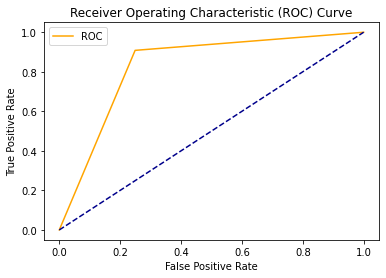

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    #plt.plot(fpr,tpr,label="AUC="+str(round(auc,4)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

#y_true = y_test[10:len(aa)]
#y_scores = aa[10:len(aa)]
y_true = y_test
y_scores =yy

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print(roc_auc_score(y_true, y_scores))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
plot_roc_curve(fpr, tpr)

# fix this code


In [ ]:
pip install pyod 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=a5f63d0182c1cc2a8a7e46eb0d5f4dc2e75aca1165bc7abbca047f21b0d759ba
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [ ]:
pip install combo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for combo: filename=combo-0.1.3-py3-none-any.whl size=42885 sha256=315576c2c481f3b6f98df2f11f3f4ee04cd027a02198be576277e9b587b10dc4
  Stored in directory: /root/.cache/pip/wheels/ec/44/39/0667fea44a2dfe692cc2a51f0f79ea49b9dee7def53594ef2e
Successfully built combo


In [ ]:
def _precision(tp,fp):
    pre = tp / float(tp + fp)
    return pre 

def _recall(tp,fn):
    rec= tp / float(tp + fn)
    return rec 

def _f1(pre,rec):
    '''
    F1 = 2 * (precision * recall) / (precision + recall)
    '''
    f1 = 2 * (pre * rec) / (pre + rec)
    return f1

def print_results(accuracy, pre, rec, f1,roc):
    print("Accuracy: {}%".format(round(accuracy*100,2)))
    print("Precision: {}%".format(round(pre*100,2)))
    print("Recall: {}%".format(round(rec*100,2)))
    print("F1 Score: {}%".format(round(f1*100,2)))
    print("ROCAUC: {}%".format(round(roc*100,2)))
    
def calculate_results_print(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TP = cm[0,0]
    TN = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    accuracy = accuracy_score(y_test, y_pred)
    precision = _precision(TP,FP)
    recall = _recall(TP,FN)
    f1 = _f1(precision,recall)
    roc = roc_auc_score(y_test, y_pred)
    print_results(accuracy, precision, recall, f1,roc)

In [ ]:
from pyod.models.ecod import ECOD
from pyod.models.abod import ABOD
from pyod.models.lunar import LUNAR
from pyod.models.vae import VAE
from pyod.models.alad import ALAD
from pyod.models.so_gaal import SO_GAAL
from pyod.models.knn import KNN
#KNN(method='mean',contamination=outliers_fraction)

In [ ]:
pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Model Spaces -> define the parameter area across which to optimize
knn_space = {"contamination": hp.uniform("contamination",0.1, 0.25),
             "method" : hp.choice("method",['largest', 'mean', 'median']),
             "algorithm" : hp.choice("algorithm", ['auto', 'ball_tree', 'kd_tree'])}

vae_space = {"gamma": hp.uniform("gamma", 0.5, 3),
            "batch_size" : hp.choice("batch_size", [32,64,128,256,512]),
            "epochs" : hp.choice("epochs", [10,25,50,100,250]),
            "dropout_rate" : hp.uniform("dropout_rate", 0.1, 0.7),
            "contamination": hp.uniform("contamination",0.1, 0.25),
            "l2_regularizer" :hp.uniform("l2_regularizer", 0.1, 0.7)}

so_gaal_space = {"contamination": hp.uniform("contamination",0.1, 0.25),
                 "lr_d": hp.uniform("lr_d", 0.0001,0.01),
                 "lr_g": hp.uniform("lr_g", 0.00001,0.001),
                 "momentum": hp.uniform("momentum", 0.1,0.9) }

alad_space = {"batch_size" : hp.uniform("batch_size", 32, 256),
              "contamination": hp.uniform("contamination",0.1, 0.25),
              "dropout_rate" : hp.uniform("dropout_rate", 0.1, 0.7)}

ecod_space = {"contamination": hp.uniform("contamination",0.1, 0.25)}

abod_space = {"contamination": hp.uniform("contamination",0.1, 0.25),
              "n_neighbors":hp.uniform("n_neighbors",10, 50)}

lunar_space = {"model_type": hp.choice("model_type",['WEIGHT', 'SCORE']),
               "n_neighbors":hp.uniform("n_neighbors",5, 25),
               "negative_sampling" : hp.choice("negative_sampling",['UNIFORM', 'SUBSPACE', 'MIXED']),
               "val_size": hp.uniform("val_size",0.1, 0.25),
               "epsilon": hp.uniform("epsilon",0.05, 0.2),
               "lr": hp.uniform("lr",0.0001, 0.01),
               "wd": hp.uniform("wd",0.05, 0.2) }




In [ ]:
def objective(space):
    # Instantiate the classifier
    clf = VAE(epochs = space["epochs"],gamma = space["gamma"],
              batch_size = space["batch_size"],
              dropout_rate = space["dropout_rate"],
              contamination = space["contamination"],
              l2_regularizer = space["l2_regularizer"] )
    
  
    
    # Fit the classsifier
    clf.fit(X_train)
    
    # Predict on Cross Validation data
    pred = clf.predict(X_test)
    
    # Calculate our Metric - accuracy
    #accuracy = accuracy_score(pred, pred>0.5)
    accuracy = f1_score(y_test,pred)
# return needs to be in this below format. We use negative of accuracy since we want to maximize it.
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
from hyperopt import Trials
trials = Trials()
best = fmin(fn=objective,
            space=vae_space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials)
print(best)

In [ ]:
im[p]
with open('Names.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=field_names)
    writer.writeheader()
    writer.writerows(cars)